<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_6%5DWriting_lyrics(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_6]Writing_lyrics(NLP)

## 1. 라이브러리 버전 확인 및 import

In [1]:
import tensorflow as tf
import glob
import re
import numpy as np
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS


print(tf.__version__)

2.8.2


## 2. 데이터 읽어오기

In [2]:
txt_file_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/lyrics/*"

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담는다.
for txt_file in txt_list:
  with open(txt_file, "r") as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)

print('데이터 크기 : ', len(raw_corpus))
print('Examples : \n', raw_corpus[:3])

데이터 크기 :  227088
Examples : 
 ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you"]


## 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

# regexr 참고
# 정규표현식을 더 추가하거나 빼거나 수정할 수 있다. 

<start> this is sample sentence . <end>


In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:

    
    # 정제를 하고 담아주세요
  preprocessed_sentence = preprocess_sentence(sentence)
  corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:20]



['<start> the first words that come out <end>',
 '<start> and i can see this song will be about you <end>',
 '<start> i can t believe that i can breathe without you <end>',
 '<start> but all i need to do is carry on <end>',
 '<start> the next line i write down <end>',
 '<start> and there s a tear that falls between the pages <end>',
 '<start> i know that pain s supposed to heal in stages <end>',
 '<start> but it depends which one i m standing on i write lines down , then rip them up <end>',
 '<start> describing love can t be this tough i could set this song on fire , send it up in smoke <end>',
 '<start> i could throw it in the river and watch it sink in slowly <end>',
 '<start> tie the pages to a plane and send it to the moon <end>',
 '<start> play it for the world , but it won t mean much <end>',
 '<start> unless i sing this song to you i m dying to show you <end>',
 '<start> this could end happily ever after <end>',
 '<start> there doesn t ever have to be disaster <end>',
 '<start> 

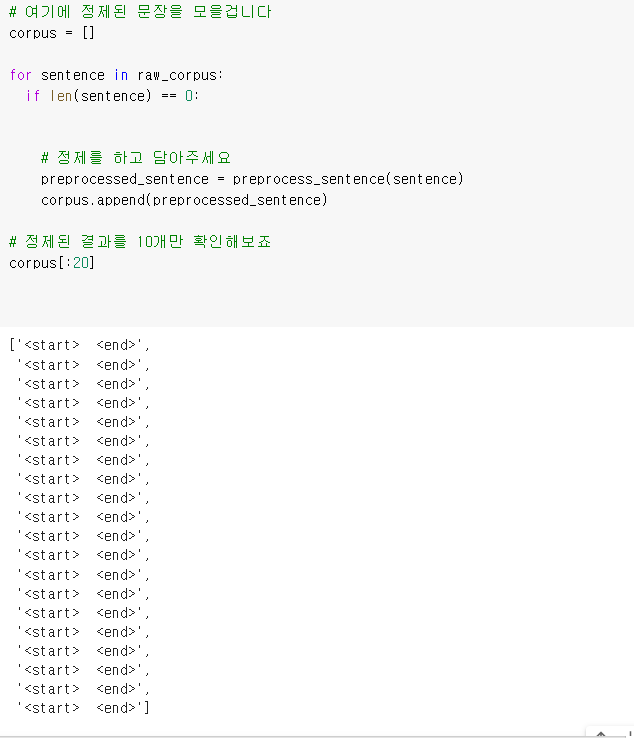

- 단어하나?? 두개 있는거 필요없으면 지우기"

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=16)  # post와 pre중 뭐가 나을지 판단하고 이유적기
    
    print(tensor,tokenizer)
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    6  198 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   39 ...    0    0    0]
 ...
 [   2  831 2474 ...    0    0    0]
 [   2  155   64 ...    0    0    0]
 [   2 4503  155 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f75cdae8c50>


In [6]:
print(tensor)

[[   2    6  198 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   39 ...    0    0    0]
 ...
 [   2  831 2474 ...    0    0    0]
 [   2  155   64 ...    0    0    0]
 [   2 4503  155 ...    0    0    0]]


In [7]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: ',', 5: 'i', 6: 'the', 7: 'you', 8: 'and', 9: 'to', 10: 'a', 11: 'it', 12: 'me', 13: 'my', 14: 'in', 15: '.', 16: 'that', 17: 's', 18: 't', 19: 'of', 20: 'on', 21: 'your', 22: 'we', 23: 'is', 24: 'm', 25: 'all', 26: 'for', 27: 'be', 28: 'like', 29: 'with', 30: 'so', 31: 'but', 32: '?', 33: 'up', 34: 'this', 35: 'what', 36: 'love', 37: 'no', 38: 'know', 39: 'can', 40: 'just', 41: 'don', 42: 'oh', 43: 'they', 44: 'got', 45: 'do', 46: '!', 47: 'when', 48: 'get', 49: 'she', 50: 'he', 51: 'now', 52: 'if', 53: 'yeah', 54: 'not', 55: 'go', 56: 'baby', 57: 'was', 58: 'out', 59: 'one', 60: 're', 61: 'll', 62: 'have', 63: 'down', 64: 'let', 65: 'her', 66: 'come', 67: 'as', 68: 'there', 69: 'see', 70: 'say', 71: 'at', 72: 'want', 73: 'from', 74: 'are', 75: 'cause', 76: 'make', 77: 'will', 78: 'time', 79: 'his', 80: 'how', 81: 'back', 82: 'man', 83: 'never', 84: 'take', 85: 'd', 86: 'girl', 87: 'here', 88: 'then', 89: 'way', 90: 'more', 91: 'right', 92: 'w

## 4. 평가 데이터셋 분리

훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [8]:
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[1])
print(tgt_input[1])

[  2   8   5  39  69  34 378  77  27 123   7   3   0   0   0]
[  8   5  39  69  34 378  77  27 123   7   3   0   0   0   0]


In [9]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=23 )

## 5.인공지능 만들기

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 502
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- 그리드서치 적용해보기

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

In [12]:
hist = model.fit(enc_train, dec_train, epochs=4,validation_data=(enc_val, dec_val))



Epoch 1/4
5678/5678 [==============================] - 365s 61ms/step - loss: 2.7034 - val_loss: 2.4475
Epoch 2/4
5678/5678 [==============================] - 347s 61ms/step - loss: 2.2364 - val_loss: 2.2588
Epoch 3/4
5678/5678 [==============================] - 347s 61ms/step - loss: 1.8855 - val_loss: 2.1757
Epoch 4/4
5678/5678 [==============================] - 347s 61ms/step - loss: 1.5992 - val_loss: 2.1627


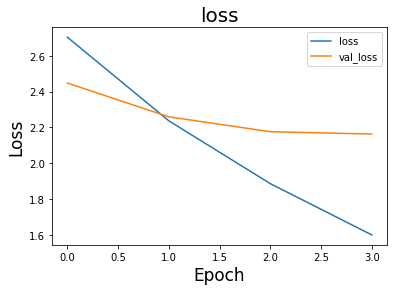

In [13]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss',fontsize=20)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss',fontsize=17)
plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

hist = model.fit(X_train, Y_train, 

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.

하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

- 임베딩 사이즈, 히든 사이즈, 패딩 임배딩과 히든을 그리드서치 처럼할수 있을 듯
- dataset하는거 할수도 있ㄱ 안해도 된다.
- max-len 조절
- 벨류데이텬 로스 -> https://tykimos.github.io/2017/07/09/Training_Monitoring/

- 2022.08.07 -> 그리드 서치가 중요할 듯

In [14]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [15]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

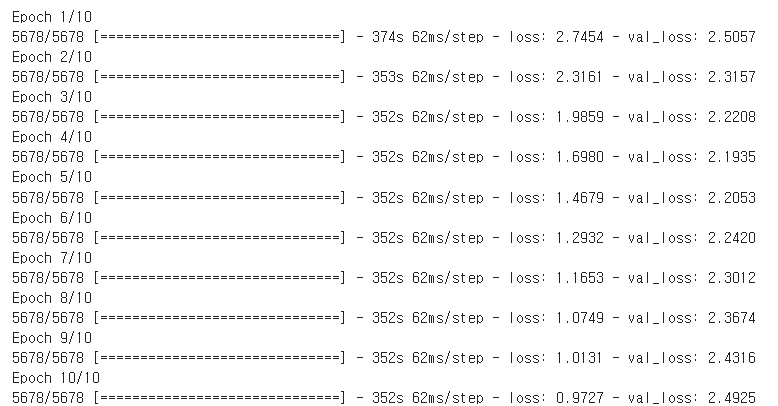